In [1]:
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import anndata as ad

In [2]:
cell_annot = pd.read_csv('../cell_annotations.tsv', sep='\t', index_col=0)

In [3]:
# scRNA data (from .loom)
adata_rna = scv.read("../velocyto/10X_multiome_mouse_brain.loom", cache = True)
adata_rna.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata_rna.obs_names]
adata_rna.var_names_make_unique()

In [4]:
# scATAC data (imputation, from h5ad)
adata_atac_imp = sc.read_h5ad("../adata.h5ad")
# Change X from binary to imputation
adata_atac_imp.X = adata_atac_imp.obsm["impute"]

In [5]:
# scRNA data basic filtering
sc.pp.filter_cells(adata_rna, min_counts=1000)
sc.pp.filter_cells(adata_rna, max_counts=20000)

In [6]:
# Add cell type information in scRNA data
adata_rna = adata_rna[cell_annot.index,:]
adata_rna.obs['celltype'] = cell_annot['celltype']

In [7]:
# Remove cell type not needed in scRNA data
adata_rna = adata_rna[adata_rna.obs['celltype'].isin(['RG, Astro, OPC', 
                                                      'IPC', 
                                                      'V-SVZ', 
                                                      'Upper Layer', 
                                                      'Deeper Layer', 
                                                      'Ependymal cells', 
                                                      'Subplate'])]

In [8]:
# scRNA data normalization 
scv.pp.filter_and_normalize(adata_rna, min_shared_counts = 30, n_top_genes = 2000)

Filtered out 23796 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [9]:
# scATAC data normalization
sc.pp.normalize_total(adata_atac_imp, target_sum = 1e4)

In [10]:
# Find shared barcodes in scRNA and scATAC data
shared_cells = pd.Index(np.intersect1d(adata_rna.obs_names, adata_atac_imp.obs_names))

In [11]:
# Extract cell with shared barcodes
adata_rna = adata_rna[shared_cells, :]
adata_atac_imp = adata_atac_imp[shared_cells, :]

In [12]:
# scATAC data
sc.pp.log1p(adata_atac_imp)

In [13]:
gene_list = list(adata_rna.var_names)

In [14]:
peak_annotation = pd.read_table("../e18_mouse_brain_fresh_5k_atac_peak_annotation.tsv")

In [15]:
def find_promoter(cols, gene_list, gene_dictionary):
    if cols["peak_type"] != "intergenic":
        genes = cols["gene"].split(";")
        peak_types = cols["peak_type"].split(";")
        for gene, peak_type in zip(genes, peak_types):
            if gene not in gene_list:
                continue
            if peak_type != "promoter":
                continue
            peak = cols["peak"].split("_")
            peak = f"{peak[0]}:{peak[1]}-{peak[2]}"
            gene_dictionary[gene] = peak

In [16]:
gene_dictionary = {}
peak_annotation.apply(find_promoter, axis = 1, gene_list = gene_list, gene_dictionary = gene_dictionary)

0         None
1         None
2         None
3         None
4         None
          ... 
144432    None
144433    None
144434    None
144435    None
144436    None
Length: 144437, dtype: object

In [17]:
final_gene = gene_dictionary.keys()

In [18]:
adata_rna = adata_rna[:, pd.Index(final_gene)]

In [19]:
final_peak = gene_dictionary.values()

In [20]:
adata_atac_imp = adata_atac_imp[:, pd.Index(final_peak)]

In [21]:
adata_rna.obs['celltype'] = cell_annot.loc[adata_rna.obs_names, 'celltype']
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].astype('category')

In [22]:
all_clusters = ['Upper Layer',
                'Deeper Layer',
                'V-SVZ',
                'RG, Astro, OPC',
                'Ependymal cells',
                'IPC',
                'Subplate']
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].cat.reorder_categories(all_clusters)

In [23]:
scv.pp.moments(adata_rna, n_pcs = 30, n_neighbors = 30)

computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [24]:
sc.tl.leiden(adata_rna)

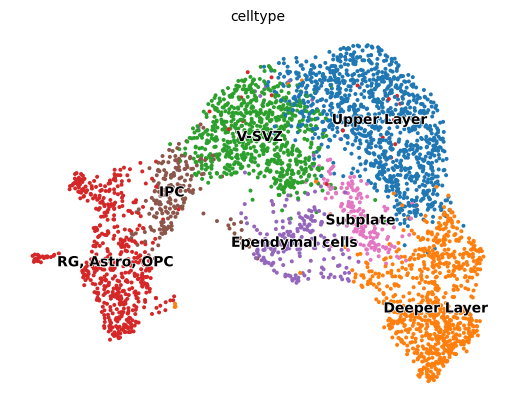

In [25]:
scv.tl.umap(adata_rna)
scv.pl.umap(adata_rna, color='celltype')

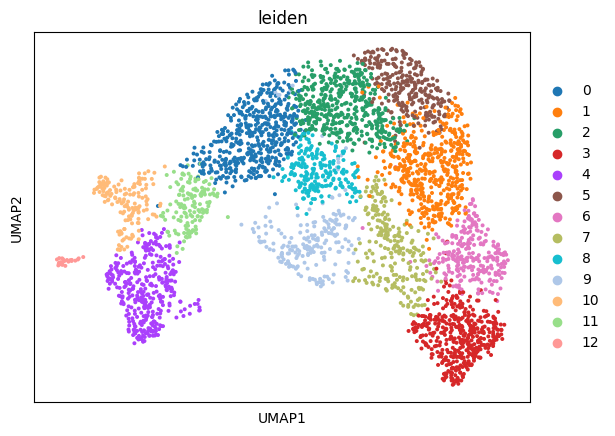

In [26]:
sc.pl.umap(adata_rna, color = "leiden")

In [27]:
adata_rna.uns["iroot"] = np.flatnonzero(adata_rna.obs["leiden"] == '11')[20]

In [28]:
sc.tl.dpt(adata_rna)

In [29]:
adata_rna.write_h5ad("data/JuloVelo_rna.h5ad")
adata_atac_imp.write_h5ad("data/JuloVelo_atac.h5ad")